# The problem
On the interval $(0, 1)$, we consider a steady-state diffusion-reaction equation,

\begin{equation}
    -Du'' + \lambda u = f(x), \quad x \in \Omega := (0,1),
\end{equation}
with for assignment I homogeneous Neumann boundary conditions:
\begin{equation}
    -Du'(0)=-Du'(1)=0,
\end{equation}
and for assignment II mixed boundary conditions:
\begin{equation}
    u(0) = 1, \quad D\frac{\text{d}u}{\text{d}x}(1) + u(1) = 1.
\end{equation}

# The FEM class

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from itertools import product
from enum import Enum

In [2]:
class Assignment(Enum):
    I  = 0
    II = 1

class FEM_1D():
    
    def __init__(self,
                 n          = 10,
                 D          = 1,
                 labda      = 1,
                 RHS_func   = lambda x: 1,
                 int_min    = lambda x: 1,
                 int_plus   = lambda x: 1,
                 Assignment = Assignment.I
                 ):
        """Class to apply FEM with linear elements to the above problem."""
        
        self.n          = n
        self.D          = D
        self.labda      = labda
        self.RHS_func   = np.vectorize(RHS_func)
        self.Assignment = Assignment
        
        # These are analytical expressions for the integrals
        # in A and B respectively in the analytical solution
        self.int_min  = int_min
        self.int_plus = int_plus
        
    def compute_exact(self):
        """Compute the exact solution in the vertices."""
        
        C         = np.sqrt(self.labda/self.D)
        SQ        = np.sqrt(self.labda*self.D)
        exp_plus  = np.exp(C)
        exp_min   = np.exp(-C)
        
        if self.Assignment == Assignment.I:
            c1_enum   = exp_plus*self.int_min(1) + exp_min*self.int_plus(1)
            c1_denom  = 2*SQ*(exp_plus - exp_min)
            c1        = c1_enum/c1_denom
            c2        = c1

        elif self.Assignment == Assignment.II:
            alpha = (1+SQ)*exp_plus
            beta  = (1-SQ)*exp_min
            gamma = (-(1/SQ+1)*exp_plus*self.int_min(1)+(1/SQ-1)*exp_min*self.int_plus(1))/2
            c1    = (beta+gamma-1)/(beta-alpha)
            c2    = (-alpha-gamma+1)/(beta-alpha)
        
        A         = -self.int_min(self.x)/(2*SQ)  + c1
        B         =  self.int_plus(self.x)/(2*SQ) + c2
        self.u_ex = A*np.exp(C*self.x) + B*np.exp(-C*self.x)
        
    def compute_error(self):
        """Compute the the error of the FEM solution w.r.t. the exact solotion
        as the maxixmum absolute difference in the vertices."""
        
        self.error         = self.u_ex - self.u_fem
        self.max_abs_error = np.max(np.abs(F.error))
        
    def femsolve1d(self, plot = True):
        """Execute the entire FEM calculation."""
        
        self.GenerateMesh()
        self.GenerateTopology()
        self.AssembleMatrix()
        self.AssembleVector()
        
        if self.Assignment == Assignment.II:
            self.ProcessEssentialBoundaryConditions()
        
        self.u_fem = np.linalg.solve(self.S,self.f)
        
        self.compute_exact()
        
    def plot(self, save = None):
        """Plot the FEM and exact solutions, and the error."""
        
        self.compute_error()
        
        fig, (ax_sols, ax_error) = plt.subplots(1,2, figsize = (10,5))
        
        ax_sols.plot(self.x,self.u_fem, label = '$u_{FEM}$')
        ax_sols.plot(self.x,self.u_ex,  label = '$u_{exact}$')
        ax_sols.set_xlabel("$x$")
        ax_sols.legend()
        
        ax_error.plot(self.x,self.error, label = 'Error $u_{exact}-u_{FEM}$')
        ax_error.set_xlabel("$x$")
        ax_error.legend()
        
        if type(save) == str:
            plt.savefig(save)
        
        plt.show()
        
        
    def GenerateMesh(self):
        """Generate the FEM mesh."""
        
        self.h = 1/(self.n-1)
        self.x = np.linspace(0,1,self.n)
        
    def GenerateTopology(self):
        """Generate the FEM topology."""
        
        self.elmat = np.zeros((self.n-1,2), dtype = int)
        
        for i in range(self.n-1):
            
            self.elmat[i,0] = i
            self.elmat[i,1] = i+1
            
    def GenerateElementMatrix(self,i):
        """Generate the element matrix."""

        S_elem      = np.zeros((2,2))
        S_elem[0,0] = self.D/self.h + self.labda*self.h/3
        S_elem[1,1] = S_elem[0,0]
        S_elem[0,1] = -self.D/self.h + self.labda*self.h/6
        S_elem[1,0] = S_elem[0,1]
        
        return S_elem
        
    def GenerateBoundaryElementMatrix(self):
        """Generate the boundary element matrix for Assignment II."""
            
        S_belem = 1
        
        return S_belem
        
        
    def AssembleMatrix(self):
        """Assemble the matrix S of the linear system resulting from FEM."""
        
        S = np.zeros((self.n,self.n))
            
        for i in range(self.n-1):
                
            S_elem = self.GenerateElementMatrix(i)

            for j,k in product([0,1], repeat = 2):  
                S[self.elmat[i,j],self.elmat[i,k]] += S_elem[j,k]
                
        if self.Assignment == Assignment.II:
            S_belem = self.GenerateBoundaryElementMatrix()
            S[self.n-1,self.n-1] += S_belem
            
        self.S = S
        
    def GenerateElementVector(self,i):
        """Generate the element vector."""
        
        f_elem = self.h/2  * np.array([self.RHS_func(self.x[i]),self.RHS_func(self.x[i+1])])
        
        return f_elem
        
    def GenerateBoundaryElementVector(self):
        """Generate the boundary element vector for Assignment II."""
            
        f_belem = 1
        
        return f_belem
        
    def AssembleVector(self):
        """Assemble the RHS vector f of the linear system resulting from FEM."""
        
        f = np.zeros((self.n,))
        
        for i in range(self.n-1):
            
            f_elem = self.GenerateElementVector(i)

            for j in [0,1]:
                f[self.elmat[i,j]] += f_elem[j]
                
        if self.Assignment == Assignment.II:
                
            f_belem = self.GenerateBoundaryElementVector()
            f[self.n-1] += f_belem
            
        self.f = f
        
    def ProcessEssentialBoundaryConditions(self):
        """Adapt the linear system in Assignment II to the essential boundary conditions."""
        
        self.f[1]   -= self.S[1,0]
        self.S[0,:]  = 0
        self.S[:,0]  = 0
        self.S[0,0]  = 1
        self.f[0]    = 1
            

# Assignments

## Assignment I.10

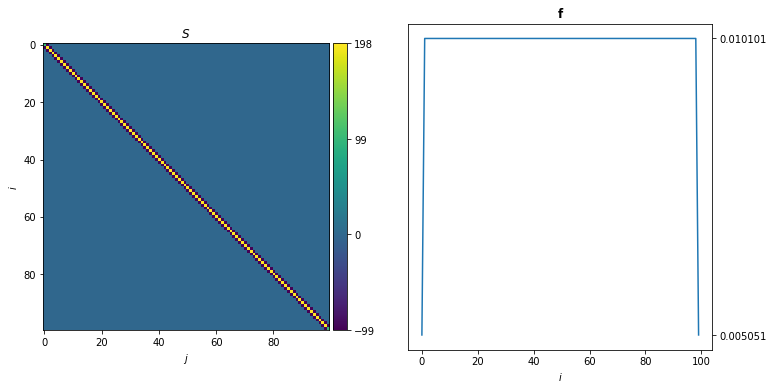

In [3]:
F = FEM_1D(n = 100, Assignment = Assignment.I)
F.femsolve1d()

fig, axs = plt.subplots(1,2, figsize = (12,6))

S_im = axs[0].imshow(F.S)
axs[0].set_title('$S$')
axs[0].set_xlabel('$j$')
axs[0].set_ylabel('$i$')

divider = make_axes_locatable(axs[0])
cax     = divider.append_axes('right', size='5%', pad=0.05)
cbar    = plt.colorbar(S_im, cax = cax)
cbar.set_ticks(np.unique(F.S))

axs[1].plot(F.f)
axs[1].set_title('$\mathbf{f}$')
axs[1].set_xlabel('$i$')
axs[1].yaxis.tick_right()
axs[1].set_yticks(np.unique(F.f))

plt.savefig('ass_I_10.png')

## Assigment I.12

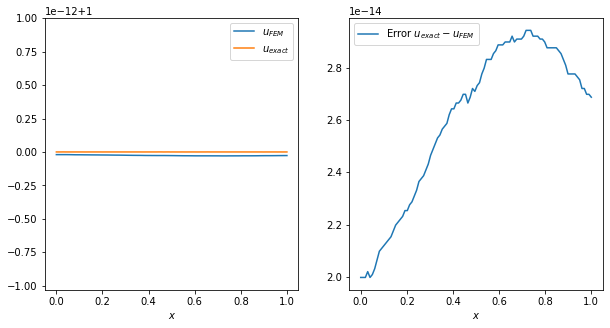

In [4]:
lamda = 1
D     = 1
C     = np.sqrt(lamda/D)

F = FEM_1D(n        = 100,
           labda    = lamda,
           D        = D,
           RHS_func = lambda x: 1,
           int_plus = lambda x:  (np.exp( C*x)-1)/C,
           int_min  = lambda x: -(np.exp(-C*x)-1)/C
          )

F.femsolve1d()
F.plot(save = 'ass_I_12_u.png')

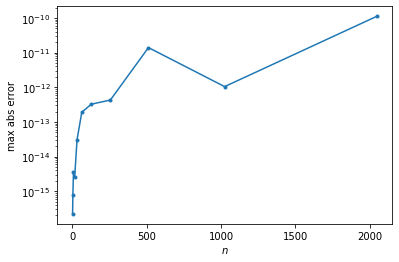

In [5]:
abs_errors = []
ns         = []

fig, ax = plt.subplots()

for i in range(1,12):
    
    n   = 2**i
    F.n = n
    
    F.femsolve1d(plot = False)
    F.compute_error()
    
    ns.append(n)
    abs_errors.append(F.max_abs_error)

ax.set_xlabel('$n$')
ax.set_ylabel('max abs error')
ax.plot(ns,abs_errors, marker = '.')
ax.set_yscale('log')
plt.savefig('ass_I_12_errors.png')
plt.show()

## Assignment I.13

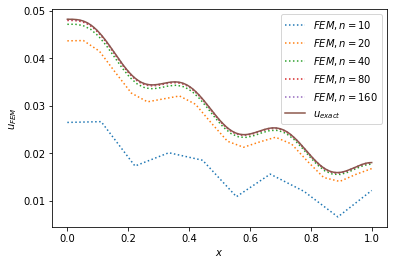

In [6]:
fig, ax = plt.subplots()
labda   = 1
D       = 1
omega   = 20
C       = np.sqrt(lamda/D)
hyp     = np.sqrt(C**2 + omega**2)
angle   = np.arctan(omega/C)
cons    = omega/(hyp**2) 

F = FEM_1D(n        = n,
           labda    = labda,
           D        = D,
           RHS_func = lambda x: np.sin(omega*x),
           int_min  = lambda x: -np.exp(-C*x)*np.sin(omega*x+angle)/hyp + cons,
           int_plus = lambda x:  np.exp( C*x)*np.sin(omega*x-angle)/hyp + cons)

for n in [10,20,40,80,160]:

    F.n = n
    F.femsolve1d(plot = False)
    
    ax.plot(F.x,F.u_fem, label = f'$FEM, n = {n}$', ls = ':')
    
F.compute_exact()
ax.plot(F.x,F.u_ex, label = '$u_{exact}$')
    
ax.legend()
ax.set_xlabel("$x$")
ax.set_ylabel("$u_{FEM}$")

plt.savefig('ass_I_13.png')
plt.show()

## Assignment II.17

True


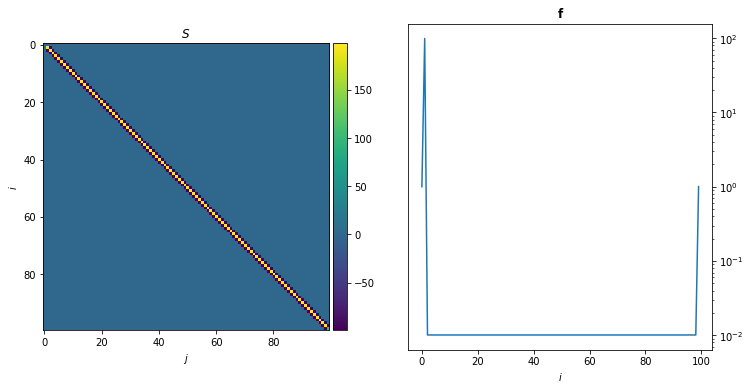

In [7]:
F = FEM_1D(n = 100, Assignment = Assignment.II)
F.femsolve1d()

fig, axs = plt.subplots(1,2, figsize = (12,6))

S_im = axs[0].imshow(F.S)
axs[0].set_title('$S$')
axs[0].set_xlabel('$j$')
axs[0].set_ylabel('$i$')

# Check symmetry
print(np.allclose(F.S,F.S.T))

divider = make_axes_locatable(axs[0])
cax     = divider.append_axes('right', size='5%', pad=0.05)
cbar    = plt.colorbar(S_im, cax = cax)

axs[1].plot(F.f)
axs[1].set_title('$\mathbf{f}$')
axs[1].set_xlabel('$i$')
axs[1].yaxis.tick_right()
axs[1].set_yscale('log')

plt.savefig('ass_II_17.png')

## Assignment II.19

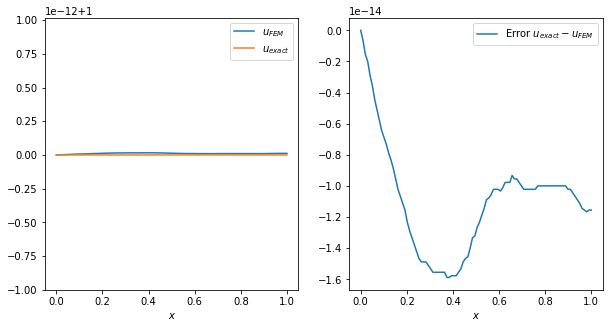

In [8]:
labda = 1
D     = 1
C     = np.sqrt(lamda/D)

F = FEM_1D(Assignment = Assignment.II,
           n          = 100,
           labda      = lamda,
           D          = D,
           RHS_func   = lambda x: 1,
           int_plus   = lambda x:  (np.exp( C*x)-1)/C,
           int_min    = lambda x: -(np.exp(-C*x)-1)/C
          )

F.femsolve1d()
F.plot(save = 'ass_II_19_u.png')

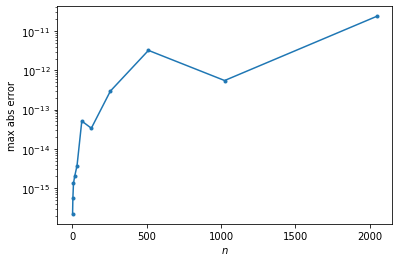

In [9]:
abs_errors = []
ns         = []

fig, ax = plt.subplots()

for i in range(1,12):
    
    n   = 2**i
    F.n = n
    
    F.femsolve1d(plot = False)
    F.compute_error()
    
    ns.append(n)
    abs_errors.append(F.max_abs_error)

ax.set_xlabel('$n$')
ax.set_ylabel('max abs error')
ax.plot(ns,abs_errors, marker = '.')
ax.set_yscale('log')
plt.savefig('ass_II_19_errors.png')
plt.show()

## Assignment II.20

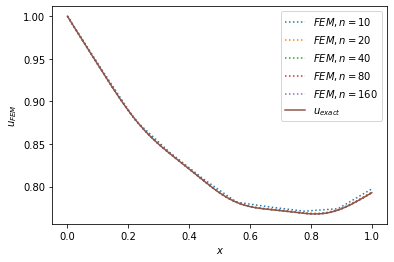

In [10]:
fig, ax = plt.subplots()
labda   = 1
D       = 1
omega   = 20
C       = np.sqrt(lamda/D)
hyp     = np.sqrt(C**2 + omega**2)
angle   = np.arctan(omega/C)
cons    = omega/(hyp**2) 

F = FEM_1D(Assignment = Assignment.II,
           n          = n,
           labda      = labda,
           D          = D,
           RHS_func   = lambda x: np.sin(omega*x),
           int_min    = lambda x: -np.exp(-C*x)*np.sin(omega*x+angle)/hyp + cons,
           int_plus   = lambda x:  np.exp( C*x)*np.sin(omega*x-angle)/hyp + cons)

for n in [10,20,40,80,160]:

    F.n = n
    F.femsolve1d(plot = False)
    
    ax.plot(F.x,F.u_fem, label = f'$FEM, n = {n}$', ls = ':')
    
F.compute_exact()
ax.plot(F.x,F.u_ex, label = '$u_{exact}$')
    
ax.legend()
ax.set_xlabel("$x$")
ax.set_ylabel("$u_{FEM}$")

plt.savefig('ass_II_20.png')
plt.show()